In [1]:
import numpy as np
import pandas as pd
import EA_funcs as eva
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(56)

benchmark_return = 0.14
benchmark_risk = 0.16

In [3]:
data = eva.all_data

returns = data.pct_change().dropna()
cumulative = (1 + returns).cumprod() - 1

final_returns = cumulative.iloc[-1]
top_performers = final_returns.sort_values(ascending=False)
top_performers = top_performers[top_performers>1].index
data = data.drop(columns=top_performers)

split = int(0.7 * len(data))
train_data = data[:split]
test_data = data[split:]

## Preliminary EA test

To start, we simply evolve a population over a few (100) generations using same set of assets as for the benchmarks notebook. For now, we restraint from performing any parameter tuning.

In [4]:
test = eva.EA(train_data, max_risk=benchmark_risk)
test.run(100)
best = test.best_chrom

The algorithm trains very quickly, in about 11 seconds and, as shown below, it already outperformed all benchmarks as it regards to returns, achieving a 16.53% return at the end of the testing period, with a risk higher than the benchmark by only 1%.

Expected return (train): 12.926%
Risk (train): 17.169%


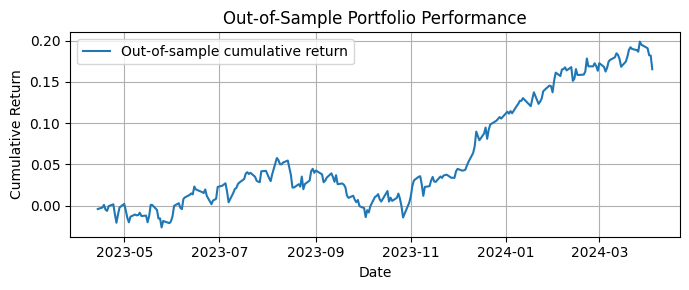

Actual return: 16.53%
Volatility during test: 10.44%


In [5]:
eva.test_portfolio_weights(best, train_data, test_data);

The following shows that all constraints are satisfied:

- All genes sum up to 1 for each chromosome, and in particular in the best solution.
- All genes in the population are below the maximum weight allowed.
- There are no negative genes.

In [6]:
print('sum of genes in best solution: ', best.sum())
print('sum of all genes in population: ', test.population[:,:-1].sum(),
                                                  f'(pop size={test.pop_size})')
print(f"Max gene weight violations in best portfolio: {(test.best_chrom > test.max_w).sum()}")
print(f"Max gene weight violations in population: {(test.population[:, :-1] > test.max_w).sum()}")
print(f"no negative weights in the population:", np.all(test.population>=0))

sum of genes in best solution:  1.0
sum of all genes in population:  100.0 (pop size=100)
Max gene weight violations in best portfolio: 0
Max gene weight violations in population: 0
no negative weights in the population: True


The plot below shows that the population is quickly converging, which reinforces our election to use a uniform parent selection, limiting the selection pressure that could otherwise lead to premature convergence. Also, it can be appreciated that the mutation operator keeps introducing diversity in the population even in later stages of the evolution, which drives further improvements even if diversity is already low, as can be seen by the upwards trend of the fitness evolution plot.

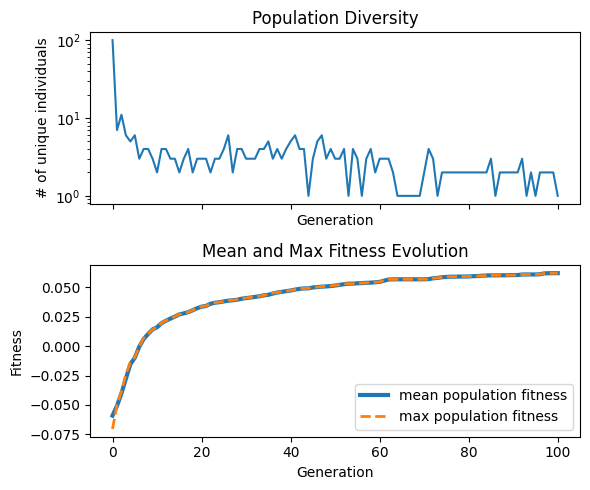

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), sharex=True)
test.plot_diversity(ax=axs[0])
test.plot_fitness(ax=axs[1])
plt.tight_layout()
plt.savefig('evolution.jpg')

### Performance

As for performance metrics, we can confirm this naive application is resulting in about average returns ($\sim 13$%) with a lower risk than the benchmark portfolios.

#### MBF (mean best fitness)

In [8]:
best_returns, risks = eva.MBF(train_data, test_data, runs=100, max_risk=benchmark_risk, generations=25)

Mean Return at the end of testing period: 13.24%
Mean Risk: 15.35%


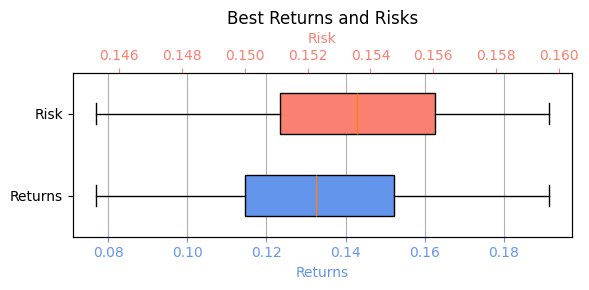

In [9]:
fig, ax1 = plt.subplots(figsize=(6, 3))

# Boxplot for best_returns on ax1
box1 = ax1.boxplot(best_returns, vert=False, positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor='cornflowerblue'))
ax1.set_yticks([1])
ax1.set_yticklabels([''])
ax1.set_xlabel('Returns', color='cornflowerblue')
ax1.tick_params(axis='x', colors='cornflowerblue')
ax1.grid(axis='x')

# Create a twin x-axis for risks
ax2 = ax1.twiny()
box2 = ax2.boxplot(risks, vert=False, positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor='salmon'))
ax2.set_yticks([2])
ax2.set_yticklabels([''])
ax2.set_xlabel('Risk', color='salmon')
ax2.tick_params(axis='x', colors='salmon')

# Set y-ticks and labels for both
ax1.set_yticks([1, 2])
ax1.set_yticklabels(['Returns', 'Risk'])

plt.title('Best Returns and Risks')
plt.tight_layout()
plt.show()

#### AES (Average fitness Evaluations to Solution) + SR (Success Rate)

92% of runs outperformed the benchmark, with an average of 5252 fitness evaluations to success, which ammounts to a few seconds due to the vectorized operations used throughought the training process.

AES: 5252.17
SR: 0.92


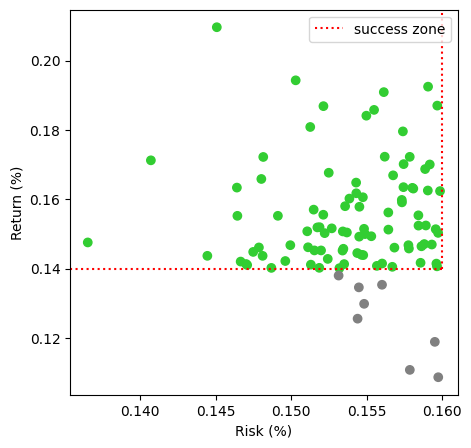

In [10]:
evals, returns, risks = eva.AES_SR(train_data, test_data, 
                                   solution=(benchmark_return, benchmark_risk), 
                                   runs=100, plot=True, max_risk=benchmark_risk)

# Parameter Selection

Next we perform a series of experiments to try and tune in the values for the main algorithm parameters. 

For this purpose we will start with exploring the effect of allowing for a larger vs. a smaller diversification, which is controlled by the parameter `w_max`: the maximum weight per asset, starting with $1/\text{\# of assets}$, which should return something close the equal weights porfolio, and up to 0.2, or 20% of the total investment, which means the portfolio could include only 5 assets.

In [11]:
# Define the range of max_w values to test
w_start = 1/(0.5 * test_data.shape[1])
ws = np.linspace(w_start, 0.2, 200)

returns = []
risks = []

# Loop over each max_w value
for w in ws:
    # Initialize and run the EA on training data
    ea = eva.EA(train_data, max_w=w)
    ea.run(25)
    
    # Compute out-of-sample return (realized return on test set)
    actual_return = 100 * ea.test_returns(test_data, ea.best_chrom)[0]
    
    # Compute in-sample risk using training covariance matrix
    model_risk = 100 * ea.volatility(ea.best_chrom)

    # Store both
    returns.append(actual_return)
    risks.append(model_risk)

We can clearly see that allowing for higher weights per asset resulted in riskier portfolios, which in general had about average returns when put to the test against future, unseen, data, with strong outliers towards the bottom (lower returns). 

In contrast, portfolios with very small allowed maximum weight per asset, and therefore high diversification, had a small training risks with below average benchmark returns by only a little bit. 

Finally, portfolios that were allowed weights a bit higher, but not to high to allow for small porfolios, achieved the best balance between risk and return.

Considering all of this we can confirms the maxim that diversification is usually the way to go, but we shouldn't overdo it. With this in mind, going forward we'll be using a w_max of 0.08.

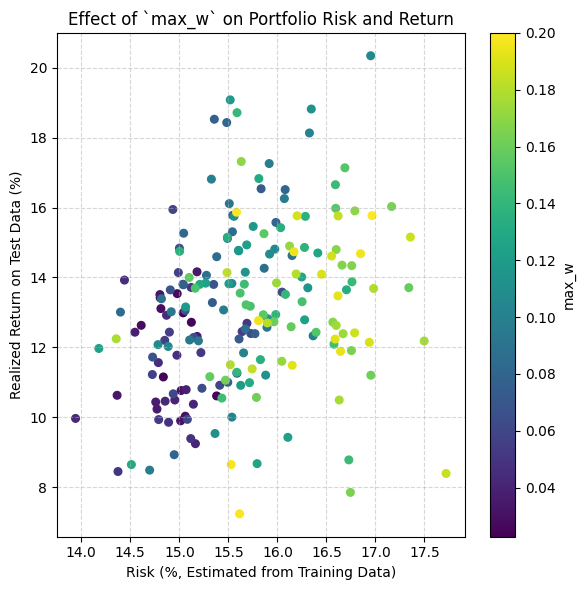

In [13]:
# Plot risk-return points, colored by max_w
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(risks, returns, c=ws, cmap='viridis', s=30)
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('max_w')

ax.set_title(r'Effect of `max_w` on Portfolio Risk and Return')
ax.set_xlabel('Risk (%, Estimated from Training Data)')
ax.set_ylabel('Realized Return on Test Data (%)')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("max_w__effect.jpg")

# Returns for different $\delta$ (risk vs. returns prioritization)

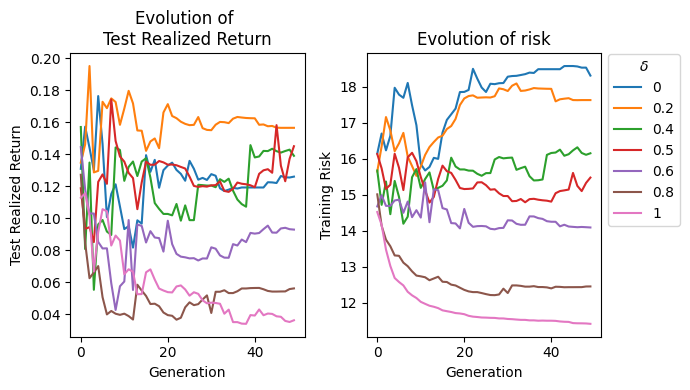

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 4))
deltas = [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1]
for delta in deltas:
    ea = eva.EA(train_data, delta=delta, max_w=0.08, max_risk=benchmark_risk)
    returns = []
    risks = []
    for i in range(50):
        ea.run(1)
        returns.append(ea.test_returns(test_data, ea.best_chrom)[0])
        risks.append(100 * ea.volatility(ea.best_chrom))
    ax[0].plot(returns)
    ax[1].plot(risks, label=delta)
    
plt.legend(bbox_to_anchor=(1, 1.02), title=r'$\delta$')
ax[0].set_ylabel('Test Realized Return')
ax[1].set_ylabel('Training Risk')
ax[0].set_xlabel('Generation')
ax[1].set_xlabel('Generation')
ax[0].set_title('Evolution of \nTest Realized Return')
ax[1].set_title('Evolution of risk')
plt.tight_layout()
plt.savefig('delta_effect_evolution.jpg')

In [26]:
deltas = np.linspace(0, 1, 10)
returns = []
risks = []

for delta in deltas:
    ea = eva.EA(train_data, delta=delta, max_w=0.08)
    ea.run(25)
    actual_return = 100 * ea.test_returns(test_data, ea.best_chrom)[0]
    risk = 100 * ea.volatility(ea.best_chrom)
    returns.append(actual_return)
    risks.append(risk)

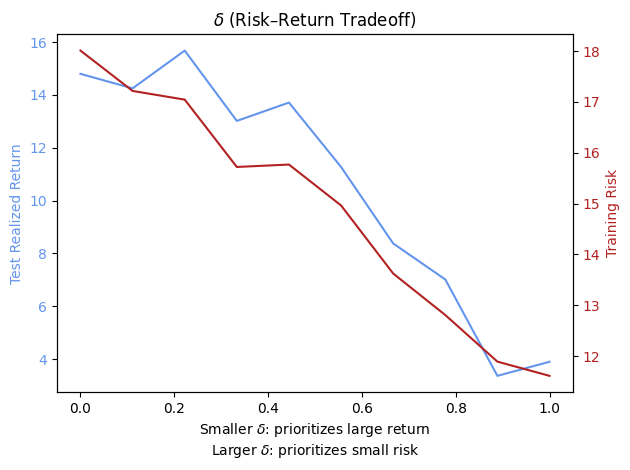

In [27]:
fig, ax1 = plt.subplots()

# Primary y-axis for returns
ax1.plot(deltas, returns, color='cornflowerblue')
ax1.set_ylabel('Test Realized Return', color='cornflowerblue')
ax1.tick_params(axis='y', labelcolor='cornflowerblue')

# Secondary y-axis for risks
ax2 = ax1.twinx()
ax2.plot(deltas, risks, color='firebrick')
ax2.set_ylabel('Training Risk', color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick')

# Shared x-axis
ax1.set_xlabel("Smaller $\delta$: prioritizes large return\nLarger $\delta$: prioritizes small risk")

# Title and layout
plt.title(r'$\delta$ (Risk–Return Tradeoff)')
fig.tight_layout()
plt.savefig('risk–return_tradeoff.jpg')

### MBF for different $\delta$.

In [ ]:
deltas = np.linspace(0, 1, 11)
mbfs = np.empty(deltas.shape)
for i, delta in enumerate(deltas):
    mbf = eva.MBF(train_data, test_data, runs=10, delta=delta, max_w=0.08, 
                  max_risk=benchmark_risk)[0].mean()
    mbfs[i] = mbf

plt.plot(deltas, mbfs)
plt.xlabel(r'$\delta$')
plt.ylabel('MBF')
plt.title('MBF Según la Tolerancia al Riesgo')
plt.savefig('MBF_vs_delta.jpg')

Mean Return at the end of testing period: 11.91%
Mean Risk: 15.98%


### Fitness vs. Risk for different $\rho$ (mutation rate)

In [ ]:
rho = np.linspace(0, 1, 11)
returns = np.empty(rho.shape)
risks = np.empty(rho.shape)
for i, ro in enumerate(ro):
    ea = EA(train_data, rho=ro, max_w=0.08)
    ea.run(50)
    best = ea.population[np.argmax(ea.pop_fitness)][:-1]
    _, r, risk = ea.fitness(best)
    returns[i] = r
    risks[i] = risk

In [ ]:
plt.plot(risks, returns, ':')
sns.scatterplot(x=risks, y=returns, hue=ks, palette='viridis', s=80)
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.title('Retorno Esperado vs. Riesgo de la Cartera \npara Distintos Valores de $k$')
plt.savefig('fit_vs_risk_vs_rho.jpg')

### Evolución de diversidad para distintas tasas de mutación ($p_m$)

In [ ]:
pm = [0.0001, 0.005, 0.01, 0.02, 0.05, 0.2]

for i, p in enumerate(pm):
    ea = EA(best100, max_w=0.07, p_m = p)
    ea.run(50)
    fit = ea.max_fit_history
    gens = range(len(fit))
    plt.plot(gens, fit, label=p)
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend(bbox_to_anchor=(1, 1.02), title=r'$p_m$')
plt.suptitle('Fitness para Distintas Tasas de Mutación')
plt.tight_layout()
plt.savefig('fitness_vs_pm.jpg')
files.download('fitness_vs_pm.jpg')

# Pruebas de Robustez

### Respecto a diferentes activos

In [ ]:
fits = asset_robustness(data=all_data, sample_size=100, pop_size=1000,
                        lambda_=6000, generations=50, max_w=0.07, p_m=0.05)
plt.title('Prueba de Robustez para Distintos Grupos de Activos')
plt.xlabel('Generación')
plt.tight_layout()
plt.savefig('asset_robustness.jpg')
fits

### Respecto a distintos periodos de tiempo

In [ ]:
fits = time_robustness(data=all_data, periods=6, pop_size=1000,
                        lambda_=6000, generations=50, max_w=0.07, p_m=0.05)
plt.title('Prueba de Robustez para Distintos Periodos de Tiempo')
plt.xlabel('Generación')
plt.tight_layout()
plt.savefig('time_robustness.jpg')
fits

In [ ]:
best_fits = []
ps = [10, 25, 50, 100, 250, 500, 1000]
for p in ps:
    ea = EA(best100, pop_size=p, lambda_=6*p, p_m=0.05, max_w=0.07,
            testing=False)
    ea.run(int(100/np.log10(p)))
    print(p, 'done')
    best_fits.append(ea.pop_fitness.max())
plt.plot(ps, best_fits)
plt.title(r'Fitness Máximo vs. $\mu$')
plt.xscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel('Fitness')
plt.tight_layout()
plt.savefig('fit_vs_pop_size.jpg')
files.download('fit_vs_pop_size.jpg')

In [ ]:
fits1, returns1, risks1 = MBF(EA, best100, p_m=0.05, max_w=0.07, pop_size=1000,
                           delta=0.51, lambda_=6000, runs=10, generations=50)

In [ ]:
returns1.mean(), returns1.std()

In [ ]:
risks1.mean(), risks1.std()

In [ ]:
evals2, returns2, risks2 = AES_SR(EA, best100, solution=0.208, max_risk=0.181,
                               max_gens=50, p_m=0.05, max_w=0.07, delta=0.51,
                               pop_size=1000, lambda_=6000, runs=30)

In [ ]:
plt.scatter(risks2, returns2)
plt.xlabel('Riesgo')
plt.ylabel('Retorno Esperado')
plt.title('Resultados de la Prueba de Desempeño')
plt.tight_layout()
plt.savefig('resultados.jpg')
files.download('resultados.jpg')

In [ ]:
test = EA(best100, p_m=0.05, max_w=0.07, pop_size=2000, lambda_=12000, delta=0.51)
best = test.population[np.argmax(test.pop_fitness)][:-1]
test.fitness(best)